## COVID-19

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from urllib.request import Request, urlopen

In [3]:
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')

### Часть 1.

Скачайте [данные](https://ourworldindata.org/coronavirus-source-data) в формате `.csv`, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших).
1. В качестве целевой переменной возьмём число случаев заболевания (столбцы `total_cases` и `new_cases`);
2. Для упрощения обработки можно заменить в столбце `new_cases` все нули на единицы;
3. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта;
4. Остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [5]:
req = Request('https://covid.ourworldindata.org/data/owid-covid-data.csv')
req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
content = urlopen(req)

covid_df = pd.read_csv(content, parse_dates=['date'])

In [6]:
print(f"DF shape: {covid_df.shape}")
covid_df.head()

DF shape: (261730, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Нас интересует Россия:

In [7]:
# select data for Russia after 2020-03-03
ru_df = covid_df[(covid_df.location == 'Russia') & (covid_df.date >= '2020-03-03')].fillna(0)
ru_df.reset_index(drop=True, inplace=True)
ru_df.index = np.arange(1, len(ru_df) + 1)

In [8]:
ru_df['new_cases'].replace(0, 1, inplace=True)  # according to the 2nd recomendation
print(f"Russian DF shape: {ru_df.shape}")
ru_df.head()

Russian DF shape: (1097, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
1,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,0.0,0.0,0.0,...,58.3,0.0,8.05,72.58,0.824,144713312.0,0.0,0.0,0.0,0.0
2,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,0.0,0.0,0.0,...,58.3,0.0,8.05,72.58,0.824,144713312.0,0.0,0.0,0.0,0.0
3,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,0.0,0.0,0.0,...,58.3,0.0,8.05,72.58,0.824,144713312.0,0.0,0.0,0.0,0.0
4,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,0.0,0.0,0.0,...,58.3,0.0,8.05,72.58,0.824,144713312.0,0.0,0.0,0.0,0.0
5,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,0.0,0.0,0.0,...,58.3,0.0,8.05,72.58,0.824,144713312.0,0.0,0.0,0.0,0.0


Создадим `train` и `test` сеты:

In [9]:
TRAIN_SIZE = 50
TEST_SIZE = 25

COLS = ['date', 'total_cases', 'new_cases']  # target variables

In [10]:
train_df = ru_df.loc[:TRAIN_SIZE, COLS]
train_df.head()

,date,total_cases,new_cases
1,2020-03-03,3.0,1.0
2,2020-03-04,3.0,1.0
3,2020-03-05,4.0,1.0
4,2020-03-06,13.0,9.0
5,2020-03-07,13.0,1.0


In [11]:
test_df = ru_df.loc[TRAIN_SIZE + 1:TRAIN_SIZE + TEST_SIZE, COLS]
test_df.head()

,date,total_cases,new_cases
51,2020-04-22,57999.0,5236.0
52,2020-04-23,62773.0,4774.0
53,2020-04-24,68622.0,5849.0
54,2020-04-25,74588.0,5966.0
55,2020-04-26,80949.0,6361.0


### Часть 2.

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [25]:
def plot_variable(variable_name):
    '''
    Plots the variable VS date dependence plot
    '''
    plt.figure(figsize=(7, 3))

    plt.plot(train_df.date, train_df[variable_name], label='train')
    plt.plot(test_df.date, test_df[variable_name], label='test')
    plt.title(variable_name.replace("_", " ").lower())
    plt.legend()
    plt.show()

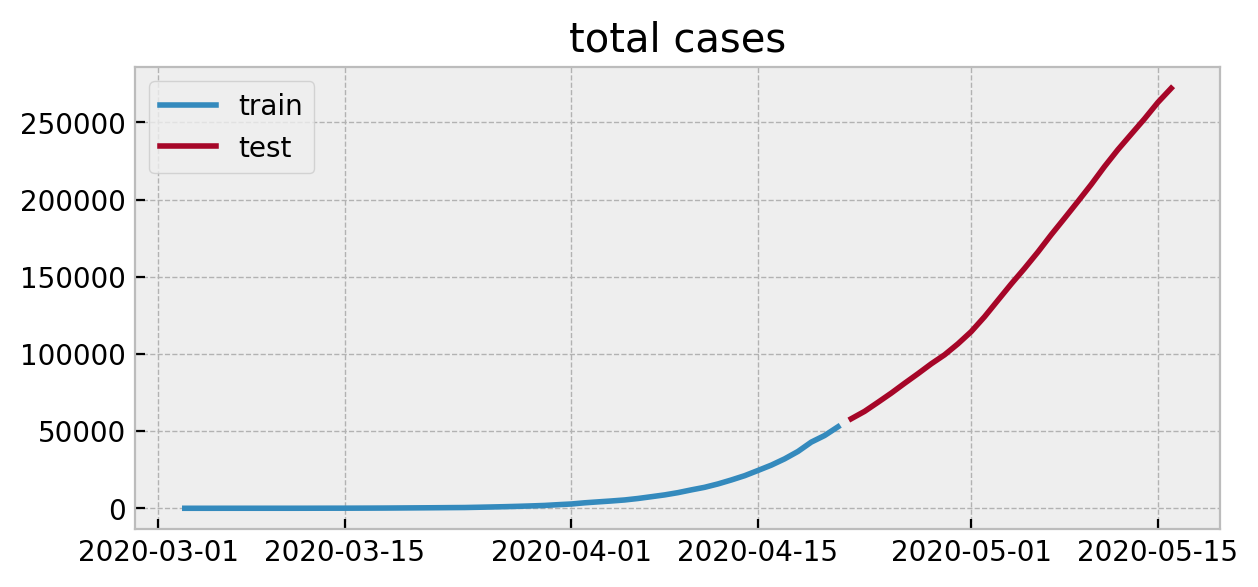

In [26]:
plot_variable('total_cases')

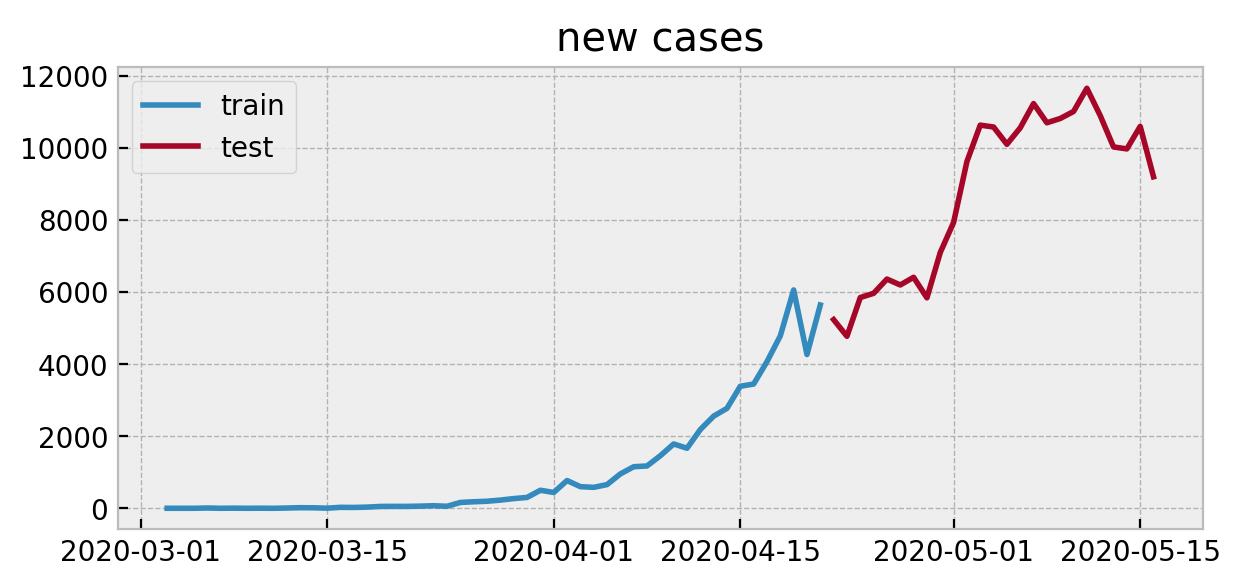

In [27]:
plot_variable('new_cases')

#### Задание 2.1

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: $y \sim \exp(w_1x+w_0)$, где $x$ — номер текущего дня.

In [28]:
# days
X_train, X_test = train_df.index.values, test_df.index.values
# total_cases
y_tot_train, y_tot_test = train_df.total_cases.values, test_df.total_cases.values
# new_cases
# y_new_train, y_new_test = train_df.new_cases.values, test_df.new_cases.values

Перейдем к обычной линейной регрессии, прологарифмировав $y$: $\log y\sim w_1x+w_0$. Таким образом будем предсказывать логарифм количества случаев.

In [29]:
lr_total_cases = LinearRegression(fit_intercept=True)
lr_total_cases.fit(X_train.reshape(-1, 1), np.log(y_tot_train));

In [44]:
lr_total_cases.coef_

array([0.19829091])

In [32]:
# to get predictions raise e to the power of prediction
y_tot_train_preds = np.exp(lr_total_cases.predict(X_train.reshape(-1, 1)))
y_tot_test_preds = np.exp(lr_total_cases.predict(X_test.reshape(-1, 1)))

print(f"Train RMSE:\t{np.sqrt(mean_squared_error(y_tot_train, y_tot_train_preds)):.2f}")
print(f"Test RMSE:\t{np.sqrt(mean_squared_error(y_tot_test, y_tot_test_preds)):.2f}")

Train RMSE:	10283.62
Test RMSE:	4948818.85


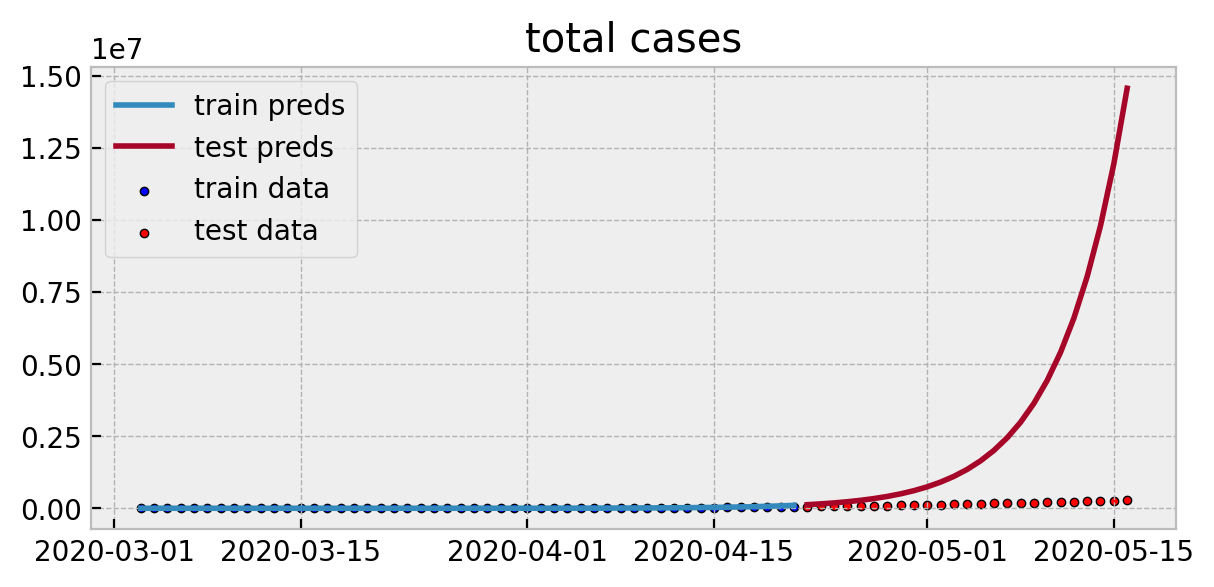

In [95]:
plt.figure(figsize=(7, 3))

# predictions
plt.plot(train_df.date, y_tot_train_preds, label='train preds')
plt.plot(test_df.date, y_tot_test_preds, label='test preds')
# real data
plt.scatter(train_df.date, y_tot_train,
            color='b', marker='.', edgecolors='k',
            label='train data')
plt.scatter(test_df.date, y_tot_test,
            color='r', marker='.', edgecolors='k',
            label='test data')

plt.title('total cases')
plt.legend()
plt.show()

#### Задание 2.2

Найдите апостериорное $p(\mathbf{w}|D)$ распределение параметров этой модели для достаточно широкого априорного $p(\mathbf{w})$ распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

$$
\begin{align}
    p(\mathbf{w}) &= \mathcal{N} (\mathbf{w} | \boldsymbol{\mu}_0=\boldsymbol{0}, \mathbf{\Sigma}_0= \sigma_0 \mathbf{I}) \\
    p(\mathbf{w}|D) &= \mathcal{N} (\mathbf{w} | \boldsymbol{\mu}_N, \mathbf{\Sigma}_N).
\end{align}
$$
Параметры апостериорного распределения определяются как
$$
\begin{align}
    \boldsymbol{\mu}_N &= \mathbf{\Sigma}_N \left[\mathbf{\Sigma}_0^{-1} \boldsymbol{\mu}_0 + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{y}\right] \\
    \mathbf{\Sigma}_N &= \left[ \mathbf{\Sigma}_0^{-1} + \frac{1}{\sigma^2}\mathbf{X}^T \mathbf{X} \right]^{-1},
\end{align}
$$
где $\sigma^2$ — дисперсия шумов в данных ($1 / \sigma^2$ — precision).

In [85]:
VAR_0 = 3


def bayes_upd(mu, sigma, X, y, var):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / var) * (X.T @ X))                  
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu + (1 / var) * (X.T @ y))
    return mu_n, sigma_n


def nth_mu_sigma(X, y, var):
    mu_0 = np.vstack(np.zeros(X.shape[1]))
    sigma_0 = VAR_0 * np.identity(X.shape[1])
    mu_n, sigma_n = bayes_upd(mu_0, sigma_0, X, y, var)
    return mu_n, sigma_n


def print_mat(mat):
    '''
    Function to print matrices
    '''
    for row_ind in range(len(mat)):
        print("\t| ", end="")
        print(*[round(x, 8) for x in mat[row_ind]], sep="\t", end="\t|\n")

In [88]:
# estimate noize sigma
var_est = (np.std(np.log(y_tot_train) - np.log(y_tot_train_preds))) ** 2
print(f"var = {sigma_est:.6f}")

var = 0.121830


In [87]:
X_tr = np.stack([np.ones(X_train.shape[0]), X_train], axis=-1)
mu, sigma = nth_mu_sigma(X_tr, np.log(y_tot_train).reshape(-1, 1), var_est)
print("mu =")
print_mat(mu)
print("sigma =")
print_mat(sigma)

mu =
	| 1.61705165	|
	| 0.19845096	|
sigma =
	| 0.01001125	-0.00029736	|
	| -0.00029736	1.167e-05	|


#### Задание 2.3

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [93]:
X_all = np.concatenate((X_train, X_test))
X_mat_all = np.stack([np.ones(X_all.shape[0]), X_all], axis=-1)

In [99]:
dates = pd.concat([train_df.date, test_df.date])

In [130]:
import datetime

In [137]:
def plot_n_exp_curves(mu, sigma, n=25):
    samples = np.random.multivariate_normal(mu.flatten(), sigma, n)
    
    plt.figure(figsize=(10, 3))
    
    results = []
    for smp in samples:
        plt.plot(dates, np.exp(X_mat_all @ smp), 'k', alpha=0.3, lw=0.05)
        results.append(np.exp(X_mat_all @ smp))
    
    plt.plot(dates, np.mean(results, axis=0),
             c='green', lw=2,
             label='mean')
    plt.scatter(train_df.date, y_tot_train,
                color='b', marker='.', edgecolors='k',
                label='train')
    plt.scatter(test_df.date, y_tot_test,
                c='r', marker='.', edgecolors='k',
                label='test')

    plt.xlim(datetime.date(2020, 4, 1), datetime.date(2020, 5, 1))
    plt.ylim(0, 5e5)
    
    plt.title('total cases')
    plt.legend()

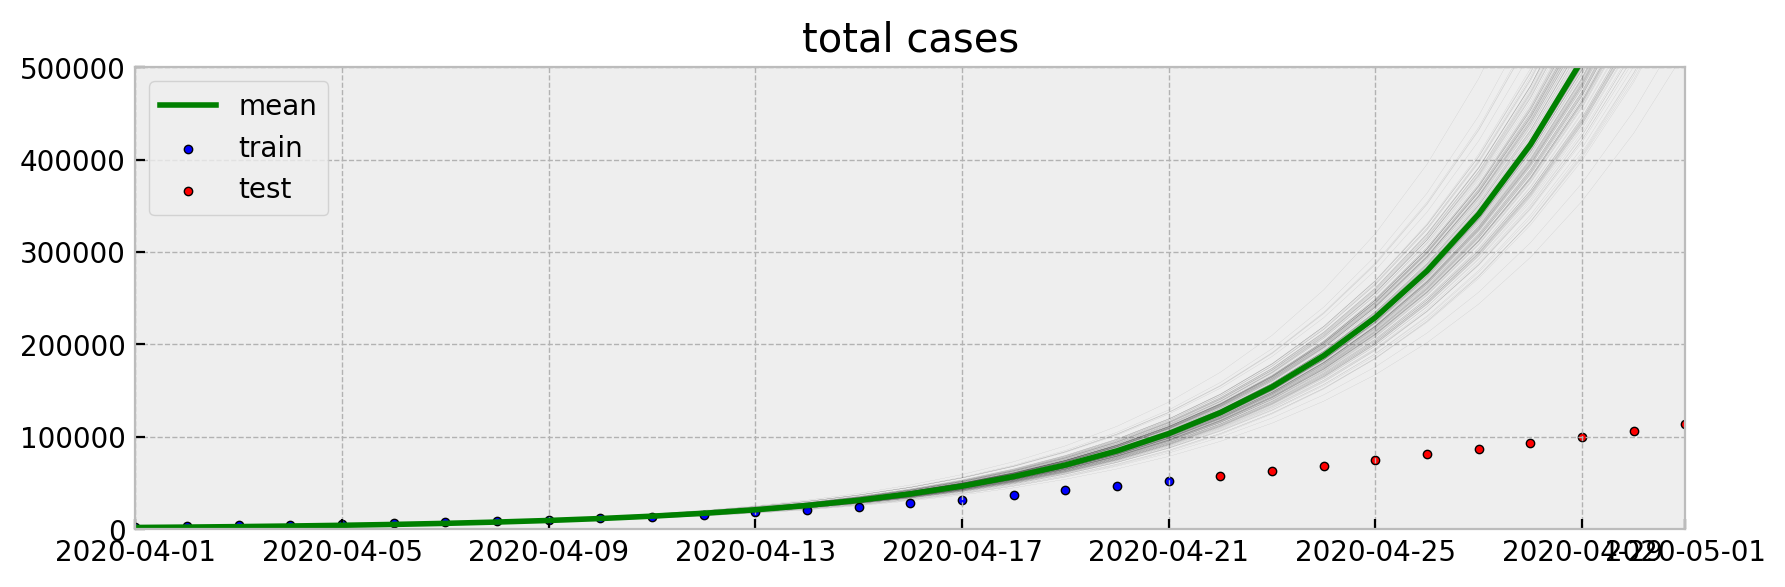

In [139]:
plot_n_exp_curves(mu, sigma, n=200)

In [177]:
def day_predict(mu, sigma, day, n=100):
    '''
    Input:
        date: str - date in format 'YYYY-MM-DD'
    '''
    day_n = ru_df.loc[ru_df.date.isin([day])].index.values
    # predict
    samples = np.random.multivariate_normal(mu.flatten(), sigma, n)
    preds = np.exp(samples @ np.array([1, day_n[0]]))
    # average
    print(f'Total cases on {day}:', int(preds.mean()))
    # plot
    plt.figure(figsize=(3, 3))
    sns.histplot(preds, bins=25)
    plt.title(day)
    plt.ylabel('total cases')
#     return preds

Total cases on 2020-05-01: 752784


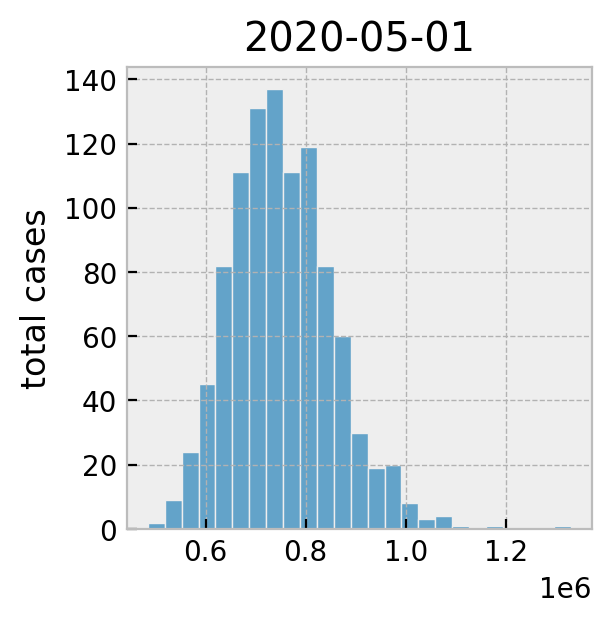

In [178]:
day_predict(mu, sigma, '2020-05-01', n=1000)

Total cases on 2020-06-01: 358851086


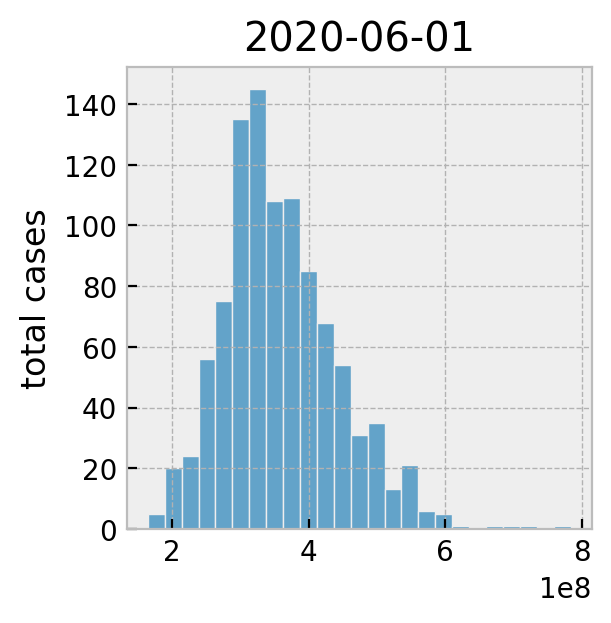

In [179]:
day_predict(mu, sigma, '2020-06-01', n=1000)

Предсказание `total_cases` к 1 июня уже больше населения России!

Total cases on 2020-09-01: 34700913355342228


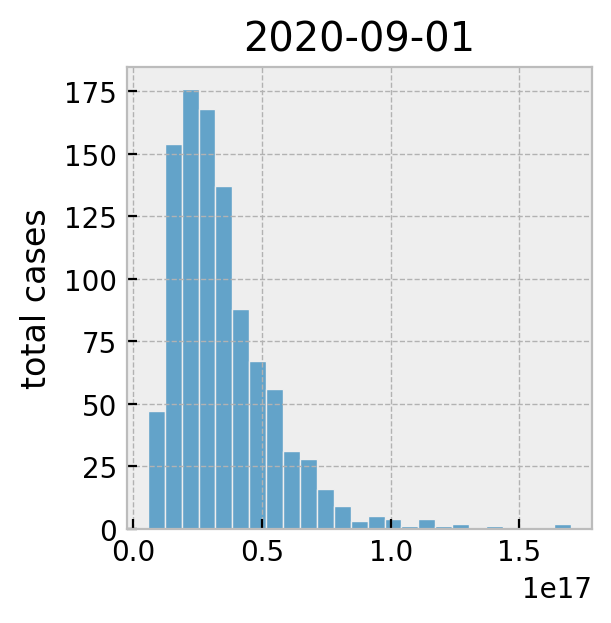

In [180]:
day_predict(mu, sigma, '2020-09-01', n=1000)

Без комментариев...

### Часть 3.

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана$^1$:

$$
\Phi = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-{t^2}/{2}} dt.
$$

_$^1$Работа ([Murray, 2020](https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1)) утверждает, что это лучший сигмоид для пандемии коронавируса, но к этой статье тоже есть вопросы, да и данных с тех пор стало больше. Честно говоря, я выбрал функцию распределения для гауссиана просто потому, что с ней будет легче всего работать._